In [2]:
import warnings 
warnings.filterwarnings("ignore")
import tensorflow as tf
import keras
import pandas as pd 
import numpy as np 
import nltk 
import spacy 
import matplotlib.pyplot as plt 
import seaborn as sn 
%matplotlib inline 
import re 
from nltk.corpus import stopwords 
stopwords=set(stopwords.words("urdu"))
import optuna 
from optuna import Trial 
from sklearn.model_selection import train_test_split 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import log_loss
from sentence_transformers import SentenceTransformer 
import torch 
import os
import random 
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score
import urduhack #for pre processing Urdu Text
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
#other required libraries will be imported at the time of requirement 

2023-01-18 16:25:07.777198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 16:25:08.006401: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-18 16:25:08.073370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-18 16:25:08.073398: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [165]:
df=pd.read_excel("Training Dataset.xlsx")
df_test=pd.read_excel("Test_data_with_truth_labels.xlsx")
#displaying first 10 rows 
display(df.head(10))
print("Shape of data is: ",df.shape)

,Tweets,label,S/G
0,بکواس مت کرو,1,1
1,تمہاری ہیجڑا فورس ایک نہتے کے سامنے بکری بنی ہ...,1,0
2,آفیسر سمیتبھارتی فوجی جہنم واصل،بنکرز تباہ بھا...,1,1
3,غدار منافق میر اللہ تمہیں زلیل کرے,1,1
4,اگست پر آپ بھارت کو کیا پیغام دینا چاہیں گے؟ م...,1,0
5,بھارت کی ایٹمی حملے کی دھمکی,1,0
6,قانون کہاں ھے ریاست کہاں ھے انصاف کہاں ھے کسی ...,1,0
7,یہ بے غیرتی چھوڑ دو,1,1
8,اس گشتی کو بھی پھینٹی لگنی چاھیے,1,1
9,بدنام ڈاکو منیر مصرانی کا کشمیر میں اپنے پچاس ...,1,1


Shape of data is:  (3564, 3)


In [164]:
display(df_test.head(10))
print("Shape of data is : ",df_test.shape)

,Tweet,Threat,G/S,uni_grams,bi_grams,tri_grams
0,وزیراعل پنجاب کا ضلع راولپنڈی کا دورہ لینڈسلائ...,0,2,"[وزیراعل, پنجاب, کا, ضلع, راولپنڈی, کا, دورہ, ...","[وزیراعل پنجاب, پنجاب کا, کا ضلع, ضلع راولپنڈی...","[وزیراعل پنجاب کا, پنجاب کا ضلع, کا ضلع راولپن..."
1,الحمدللہ پورے پاکستان وکلاء برادری کا کہنا ہم ...,1,1,"[الحمدللہ, پورے, پاکستان, وکلاء, برادری, کا, ک...","[الحمدللہ پورے, پورے پاکستان, پاکستان وکلاء, و...","[الحمدللہ پورے پاکستان, پورے پاکستان وکلاء, پا..."
2,جنوری مہلت ختم الٹی گنتی شروع ن لیگ خلاف بڑی ک...,1,1,"[جنوری, مہلت, ختم, الٹی, گنتی, شروع, ن, لیگ, خ...","[جنوری مہلت, مہلت ختم, ختم الٹی, الٹی گنتی, گن...","[جنوری مہلت ختم, مہلت ختم الٹی, ختم الٹی گنتی,..."
3,کروناکی آڑ میں حکومت اورفوج جوکھیل قادیانیوں ک...,1,1,"[کروناکی, آڑ, میں, حکومت, اورفوج, جوکھیل, قادی...","[کروناکی آڑ, آڑ میں, میں حکومت, حکومت اورفوج, ...","[کروناکی آڑ میں, آڑ میں حکومت, میں حکومت اورفو..."
4,حکومت ایکشن میں ورنہ اگر ہم ایکشن میں آگئے ہم ...,1,1,"[حکومت, ایکشن, میں, ورنہ, اگر, ہم, ایکشن, میں,...","[حکومت ایکشن, ایکشن میں, میں ورنہ, ورنہ اگر, ا...","[حکومت ایکشن میں, ایکشن میں ورنہ, میں ورنہ اگر..."
5,ہم نے مسلسل میٹنگز کیں تمام معاملات اتفاق رائے...,0,2,"[ہم, نے, مسلسل, میٹنگز, کیں, تمام, معاملات, ات...","[ہم نے, نے مسلسل, مسلسل میٹنگز, میٹنگز کیں, کی...","[ہم نے مسلسل, نے مسلسل میٹنگز, مسلسل میٹنگز کی..."
6,وزیراعظم صاحب ہوش ناخن پہچانیں ان کھٹملوں کو,0,2,"[وزیراعظم, صاحب, ہوش, ناخن, پہچانیں, ان, کھٹمل...","[وزیراعظم صاحب, صاحب ہوش, ہوش ناخن, ناخن پہچان...","[وزیراعظم صاحب ہوش, صاحب ہوش ناخن, ہوش ناخن پہ..."
7,میڈیا تمام اینکرز سے گزارش جس دن سے نے کراچی م...,0,2,"[میڈیا, تمام, اینکرز, سے, گزارش, جس, دن, سے, ن...","[میڈیا تمام, تمام اینکرز, اینکرز سے, سے گزارش,...","[میڈیا تمام اینکرز, تمام اینکرز سے, اینکرز سے ..."
8,زلفی بخاری قوم آپ سے حساب,1,1,"[زلفی, بخاری, قوم, آپ, سے, حساب, ]","[زلفی بخاری, بخاری قوم, قوم آپ, آپ سے, سے حساب...","[زلفی بخاری قوم, بخاری قوم آپ, قوم آپ سے, آپ س..."
9,عوام مارتی مر جاۓ بھاڑ میں جاۓ بھٹو کتے کا بچا...,0,2,"[عوام, مارتی, مر, جاۓ, بھاڑ, میں, جاۓ, بھٹو, ک...","[عوام مارتی, مارتی مر, مر جاۓ, جاۓ بھاڑ, بھاڑ ...","[عوام مارتی مر, مارتی مر جاۓ, مر جاۓ بھاڑ, جاۓ..."


Shape of data is :  (935, 6)


## Exploratory Data Analysis 

In [4]:
#checking null values 
df.isnull().any()

Tweets    False
label     False
S/G       False
dtype: bool

In [5]:
#cheching na values 
df.isna().any()

Tweets    False
label     False
S/G       False
dtype: bool

In [6]:
#descrbing the dataframe and its variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3564 entries, 0 to 3563
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  3564 non-null   object
 1   label   3564 non-null   int64 
 2   S/G     3564 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 83.7+ KB


In [7]:
df.describe()

,label,S/G
count,3564.00000,3564.000000
mean,0.50000,1.123737
std,0.50007,0.928005
min,0.00000,0.000000
25%,0.00000,0.000000
50%,0.50000,1.500000
75%,1.00000,2.000000
max,1.00000,2.000000


In [8]:
# removing special characters and symbols.and english alphabets

def clean_text(text):
    import emoji 
    text=emoji.replace_emoji(text,"")
    text=re.sub(r"[A-Za-z0-9@;:/<>(){}]", "", text, flags=re.UNICODE)
    return text

In [9]:
print("Part of the sentence before removal of symbols and alphabets: \n\n ",df["Tweets"][2])
df["Tweets"]=df["Tweets"].apply(clean_text)
df_test["Tweet"]=df_test["Tweet"].apply(clean_text)
print("\n\nPart of the Sentence after removal of symbols and alphabets: \n\n",df["Tweets"][2])

Part of the sentence before removal of symbols and alphabets: 

  آفیسر سمیتبھارتی فوجی جہنم واصل،بنکرز تباہ بھارت کو پتہ لگ جائے…


Part of the Sentence after removal of symbols and alphabets: 

 آفیسر سمیتبھارتی فوجی جہنم واصل،بنکرز تباہ بھارت کو پتہ لگ جائے…


## Pre Processing Text 

### Lemmatization

In [10]:
# Using Urduhack to perform the lemmatization 
import urduhack
urduhack.download()
from urduhack.normalization import normalize
from urduhack.preprocessing import normalize_whitespace, remove_punctuation, remove_accents, replace_urls, replace_emails, replace_numbers, replace_currency_symbols, remove_english_alphabets

In [11]:
# Applying UrduHack Pre Processing 
print("Part of the sentence before further pre-processing: \n\n ",df["Tweets"][2])

#Normalizing text returns the text with normalized characters, proper spaces 
df["Tweets"]=df["Tweets"].apply(normalize)
df_test["Tweet"]=df_test["Tweet"].apply(normalize)
#although we have removed the punctuation by implementing the clean_text function, we still implement the remove_punctuation function 
df["Tweets"]=df["Tweets"].apply(remove_punctuation)
df_test["Tweet"]=df_test["Tweet"].apply(remove_punctuation)
#removes accents from any accented unicode characters in text str, either by transforming them 
# or completely removing them
df["Tweets"]=df["Tweets"].apply(remove_accents)
df_test["Tweet"]=df_test["Tweet"].apply(remove_accents)
#Since the dataset is made up of from tweets it is possible to have links in the tags this function replace the urls with replace_with str
df["Tweets"]=df["Tweets"].apply(replace_urls)
df["Tweets"]=df["Tweets"].apply(replace_emails)#replace emails with replace_with str
df["Tweets"]=df["Tweets"].apply(replace_currency_symbols)#replaces the currency symbols with replace_with str
df_test["Tweet"]=df_test["Tweet"].apply(replace_urls)
df_test["Tweet"]=df_test["Tweet"].apply(replace_emails)
df_test["Tweet"]=df_test["Tweet"].apply(replace_currency_symbols)
#Since we have inserted replace_with str we need to remove it 
for sent in df["Tweets"]:
    sent=re.sub(r'["_"]'," ",sent)
for sent_test in df_test["Tweet"]:
    sent_test=re.sub(r'["_"]'," ",sent_test)
#removing english alphabets
df["Tweets"]=df["Tweets"].apply(remove_english_alphabets)
df_test["Tweet"]=df_test["Tweet"].apply(remove_english_alphabets)
#normalizing white spaces means replacing 2 or more spaces iwth one and two ormore linebreaks with one 
df["Tweets"]=df["Tweets"].apply(normalize_whitespace)
df_test["Tweet"]=df_test["Tweet"].apply(normalize_whitespace)
print("\n\nPart of the Sentence after furhter pre-processing: \n\n",df["Tweets"][2])

Part of the sentence before further pre-processing: 

  آفیسر سمیتبھارتی فوجی جہنم واصل،بنکرز تباہ بھارت کو پتہ لگ جائے…


Part of the Sentence after furhter pre-processing: 

 آفیسر سمیتبھارتی فوجی جہنم واصلبنکرز تباہ بھارت کو پتہ لگ جائے


In [12]:
#removing stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words("urdu"))
print(stopwords)#urdu stopwords

{'ثرش', 'کہ', 'زقیقت', 'زقیتیں', 'کررہی', 'گے', 'چکب', 'ًبپطٌذ', 'دکھبتی', 'دے', 'پھر', 'آیب', 'صسیر', 'یہبں', 'ارکبى', 'لیٌب', 'ہوًب', 'دیکھٌب', 'هیرا', 'تعذاد', 'خبرہی', 'درخے', 'ضکٌب', 'ثہت', 'ڈھوًڈا', 'گیب', 'ہی', 'ہن', 'غخص', 'کی', 'یقیٌی', 'کے', 'خبرہے', 'تت', 'ثہتر', 'کہٌب', 'کرتے', 'گروہوں', 'ارد', 'ہوئی', 'دیتی', 'فرد', 'هتعلق', 'خب', 'هوکٌبت', 'غے', 'ہو', 'ثہتریي', 'هیں', 'ثٌبرہی', 'ضوچی', 'درخہ', 'ضت', 'خگہیں', 'کیے', 'ہوًے', 'اکیلے', 'خص', 'رریعہ', 'کھولے', 'یہ', 'تبزٍ', 'کررہب', 'پبًب', 'ضکتے', 'هہرثبى', 'ثٌبرہب', 'لیب', 'اچھب', 'خططرذ', 'کہیں', 'ثٌبًب', 'آخرکبر', 'اش', 'ادھر', 'راضتے', 'دیب', 'درضت', 'ہوضکتی', 'چلو', 'کہو', 'ہوگیب', 'پوچھتی', 'پوچھوں', 'صورتوں', 'ثب', 'طریقہ', 'اکٹھے', 'چکی', 'ٓ آش', 'زکویہ', 'کورٍ', 'آج', 'هسیذ', 'ثبہر', 'کہتے', 'دکھبتب', 'کورا', 'تھے', 'ًبگسیر', 'ہوبرا', 'تٌہب', 'ٹھیک', 'کہے', 'کئی', 'کیطے', 'دلچطپی', 'زبلات', 'ثبئیں', 'ہوا', 'چلے', 'ڈھوًڈیں', 'ک', 'خبًب', 'چھوٹے', 'ثھرپور', 'تھوڑا', 'ضیذھے', 'آئی', 'تن', 'ثٌذ', 'چھوٹی', 'غذ', 'اطراف', 

In [13]:
def remove_stopword(text):
    return " ".join(word for word in text.split() if word not in stopwords)


In [14]:
print("Part of Sentence before the removal of the stopword : \n\n",df["Tweets"][4])
df["Tweets"]=df["Tweets"].apply(remove_stopword)
df_test["Tweet"]=df_test["Tweet"].apply(remove_stopword)
print("\n\nPart of Sentence after the removal of the stopword: \n\n",df["Tweets"][4])


Part of Sentence before the removal of the stopword : 

 اگست پر آپ بھارت کو کیا پیغام دینا چاہیں گے میرا یہ پیغام ھے کہ کشمیر سے نکل جاو ورنہ کتے کی موت مارے جاو گے کشمیر ہمارا ھے


Part of Sentence after the removal of the stopword: 

 اگست آپ بھارت کو کیا پیغام دینا چاہیں میرا پیغام ھے کشمیر سے نکل جاو ورنہ کتے موت مارے جاو کشمیر ہمارا ھے


In [15]:
# using urduhack lemmatizer for the lemmatization task
from urduhack.models.lemmatizer import lemmatizer 

def lemmatize(text):
    lemme_str=""
    temp=lemmatizer.lemma_lookup(text)
    for i in temp:
        lemme_str+=i[0]+" "
    return lemme_str

In [16]:
#applying lemmatizer
print("Part of Sentence before lemmatization : \n\n",df["Tweets"][4])
df["Tweets"]=df["Tweets"].apply(lemmatize)
df_test["Tweet"]=df_test["Tweet"].apply(lemmatize)
print("\n\nPart of Sentence after lemmatization: \n\n",df["Tweets"][4])


Part of Sentence before lemmatization : 

 اگست آپ بھارت کو کیا پیغام دینا چاہیں میرا پیغام ھے کشمیر سے نکل جاو ورنہ کتے موت مارے جاو کشمیر ہمارا ھے


Part of Sentence after lemmatization: 

 اگست آپ بھارت کو کیا پیغام دینا چاہیں میرا پیغام ھے کشمیر سے نکل جاو ورنہ کتے موت مارے جاو کشمیر ہمارا ھے 


## Text Statistics

In [17]:
#Generate Statistical Count Features
df['word_count'] = df['Tweets'].apply(lambda x : len(x.split()))
df['char_count'] = df['Tweets'].apply(lambda x : len(x.replace(" ","")))
df['word_density'] = df['word_count'] / (df['char_count'] + 1)
df[['word_count', 'char_count', 'word_density']].head(10)

,word_count,char_count,word_density
0,2,7,0.250000
1,9,37,0.236842
2,11,52,0.207547
3,6,25,0.230769
4,23,83,0.273810
5,4,19,0.200000
6,24,83,0.285714
7,3,11,0.250000
8,7,26,0.259259
9,16,66,0.238806


In [18]:
#Specifying the fonts for plots 
font_1= {'family': 'monospace',
        'color':  'white',
        'weight': 'normal',
        'size': 20,
        }
font_2=font= {'family': 'sans',
        'color':  'darkred',
        'weight': 'normal',
        'size': 20,
        }


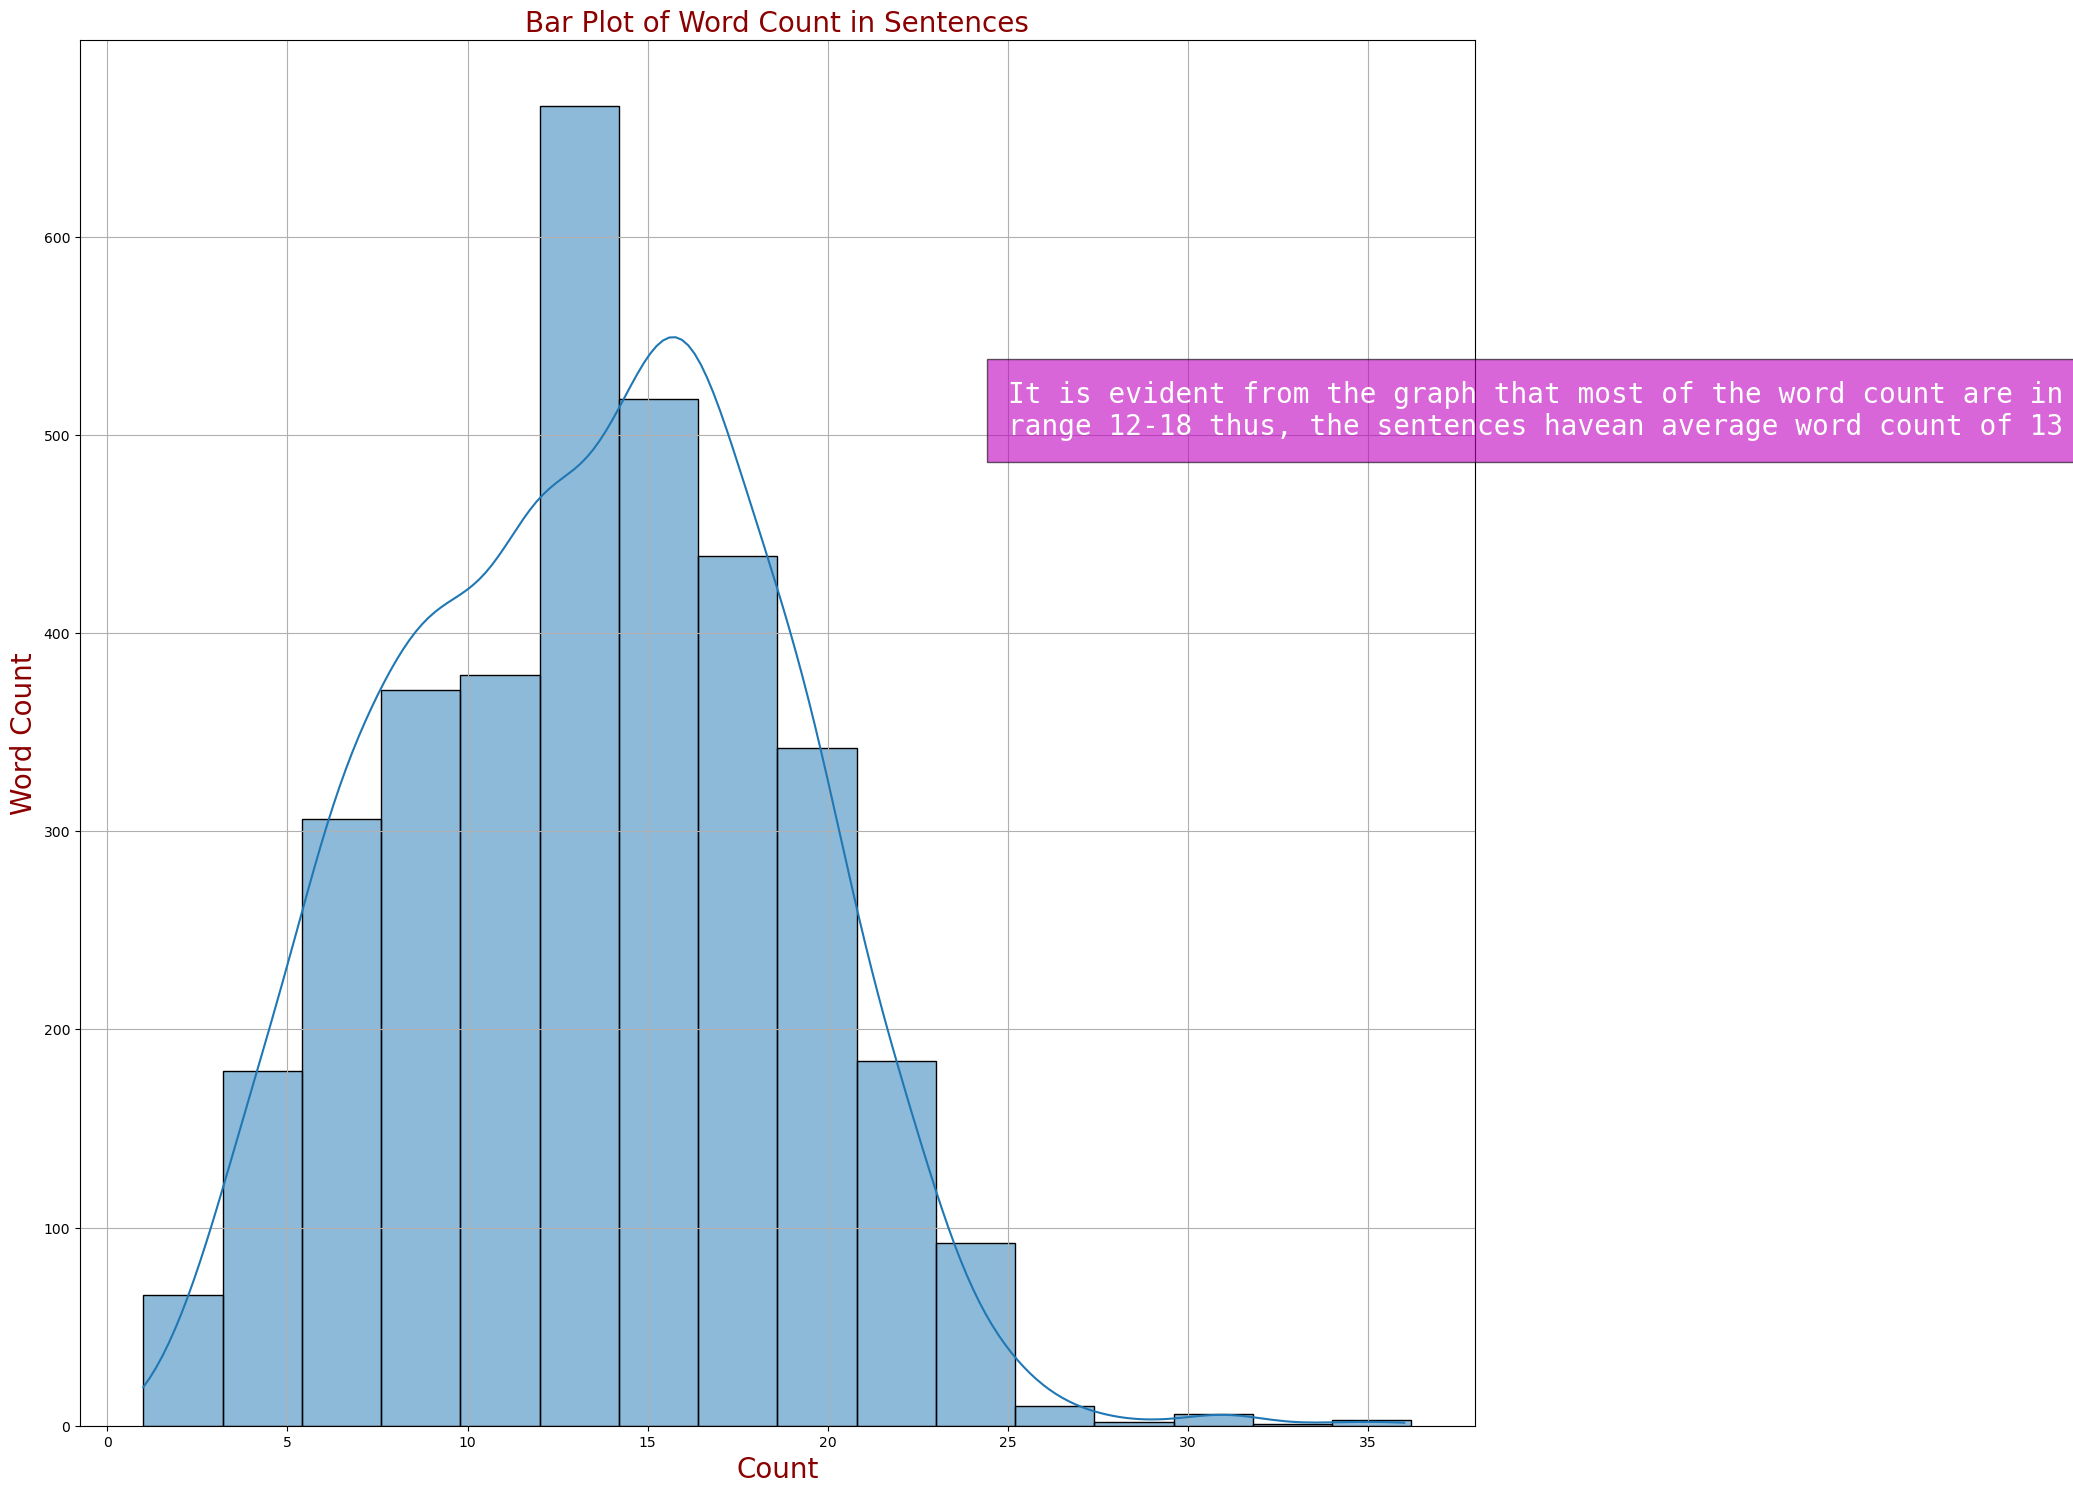

In [19]:
#visualizing statistical Count Features 
avg_wc=int(np.sum(df["word_count"])/len(df["word_count"]))
fig,ax=plt.subplots(figsize=(18,18))
sn.histplot(data=df,x="word_count",kde=True,ax=ax,binwidth=2.2)
# fig.patch.set_facecolor('xkcd:mint green')
# ax.set_facecolor('black')
plt.grid(True)
plt.title("Bar Plot of Word Count in Sentences",fontdict=font_2)
plt.xlabel("Count",fontdict=font_2)
plt.ylabel("Word Count",fontdict=font_2)
ax.text(25,500,f"It is evident from the graph that most of the word count are in\nrange 12-18 thus, the sentences have\
an average word count of {avg_wc}",fontdict=font_1,bbox={'facecolor': 'm','alpha':0.6, 'pad':15})
plt.savefig("plot1_b.jpg",bbox_inches="tight")
plt.show()

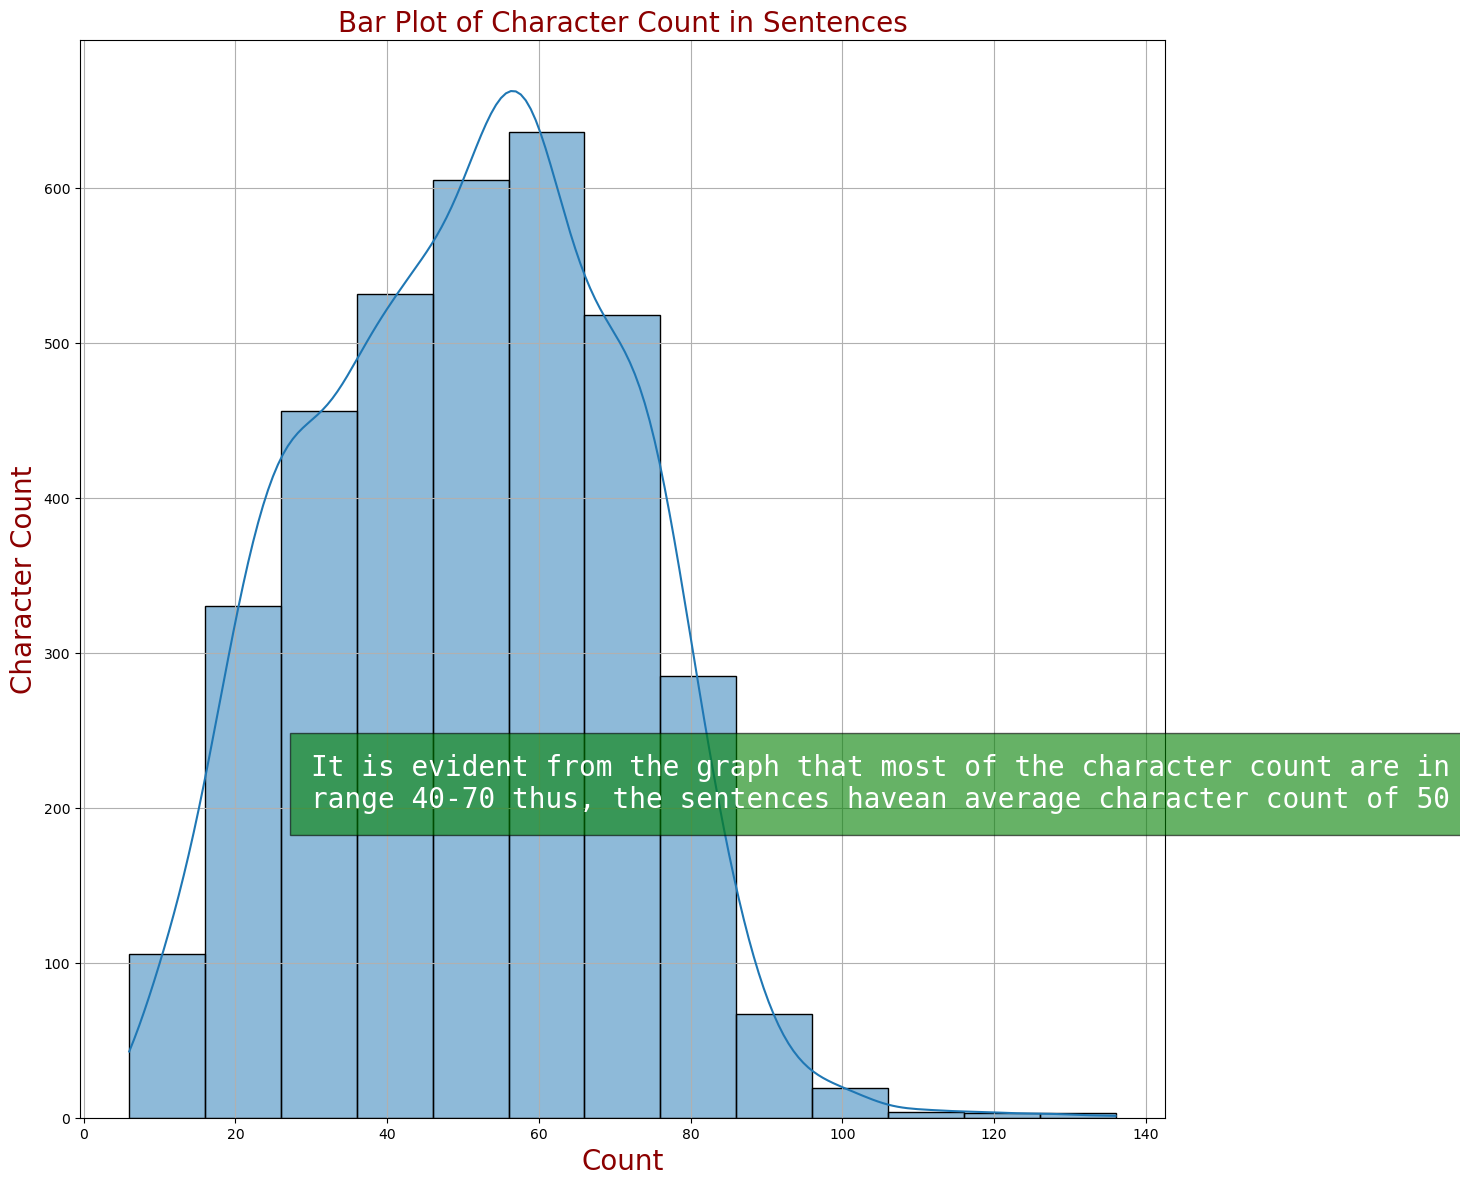

In [20]:
#visualizing statistical Count Features 
avg_cc=int(np.sum(df["char_count"])/len(df["char_count"]))
fig,ax=plt.subplots(figsize=(14,14))
sn.histplot(data=df,x="char_count",kde=True,ax=ax,binwidth=10)
# fig.patch.set_facecolor('xkcd:lightblue')
# ax.set_facecolor('xkcd:black')
plt.grid(True)
plt.title("Bar Plot of Character Count in Sentences",fontdict=font_2)
plt.xlabel("Count",fontdict=font_2)
plt.ylabel("Character Count",fontdict=font_2)
ax.text(30,200,f"It is evident from the graph that most of the character count are in\nrange 40-70 thus, the sentences have\
an average character count of {avg_cc}",fontdict=font_1,bbox={'facecolor': 'g','alpha':0.6, 'pad':15})
plt.savefig("plot2_b.jpg",bbox_inches="tight")

# N-Gram Exploration

In [21]:
# Using countvectorizer to tokenize, vectorize and represent corpus in appropriate form
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

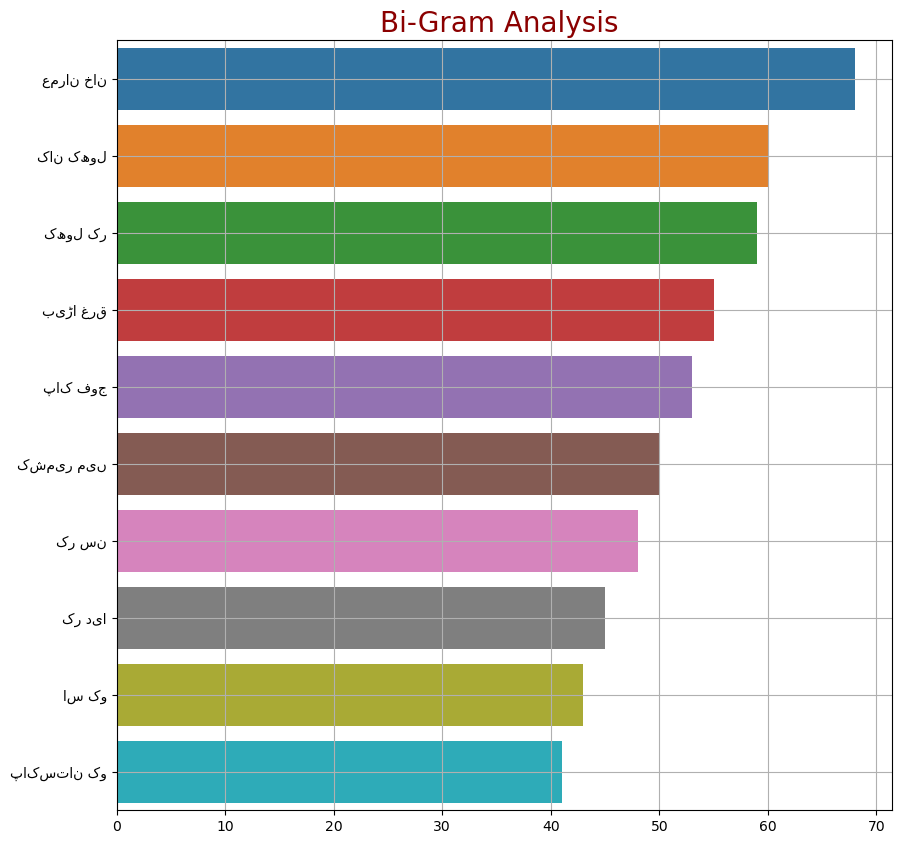

In [22]:
# first using the bigram 
top_bi_grams=get_top_ngram(df["Tweets"],n=2)
x,y=map(list,zip(*top_bi_grams))
fig,ax=plt.subplots(figsize=(10,10))
sn.barplot(x=y,y=x)
plt.title("Bi-Gram Analysis ",fontdict=font_2)
# ax.set_facecolor('xkcd:black')
# fig.patch.set_facecolor('xkcd:salmon')
plt.grid(True)
plt.savefig("plot4_b.jpg",bbox_inches="tight")
plt.show()

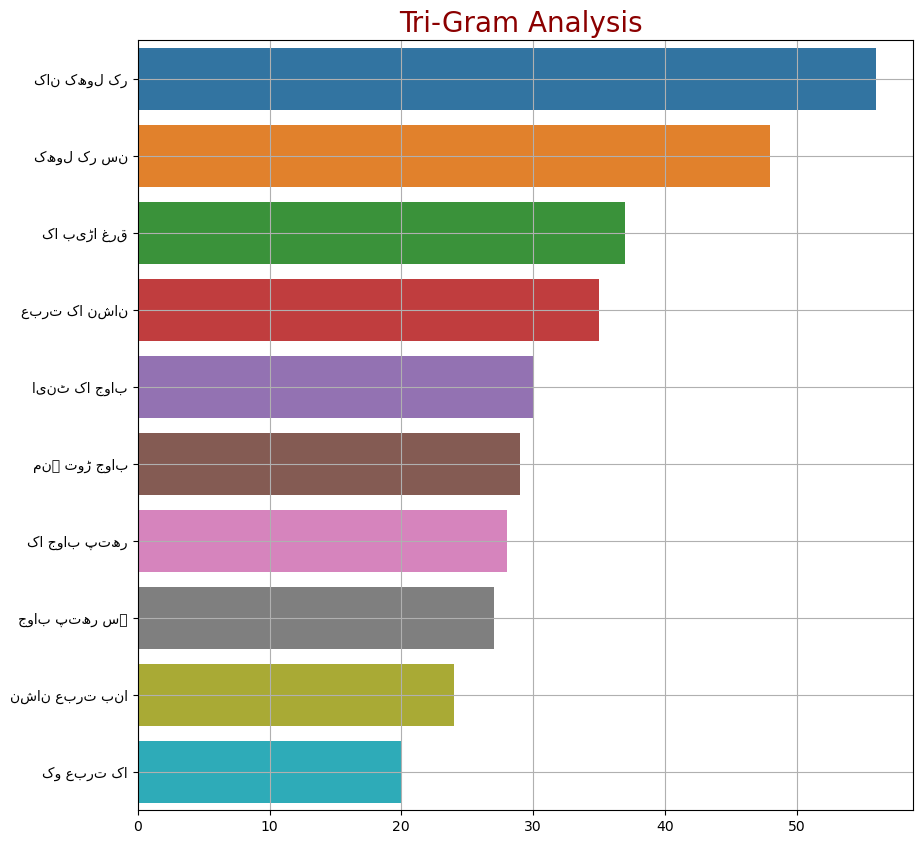

In [60]:
# first using the trigram 
top_ti_grams=get_top_ngram(df["Tweets"],n=3)
x,y=map(list,zip(*top_ti_grams))
fig,ax=plt.subplots(figsize=(10,10))
sn.barplot(x=y,y=x)
plt.title("Tri-Gram Analysis ",fontdict=font_2)
# ax.set_facecolor('xkcd:black')
# fig.patch.set_facecolor('xkcd:mint green')
plt.grid(True)
plt.savefig("plot5_b.jpg",bbox_inches="tight")
plt.show()

In [24]:
#Creating Word Cloud 
from wordcloud import WordCloud
from nltk import PorterStemmer, WordNetLemmatizer, word_tokenize
def preprocess_sentences(df):#preprocessing to create corpus
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for sentence in df['Tweets']:
        words=[w for w in word_tokenize(sentence) if (w not in stopwords)]

        words=[lem.lemmatize(w) for w in words if len(w)>2]

        corpus.append(words)
    return corpus

In [25]:
corpus=preprocess_sentences(df)

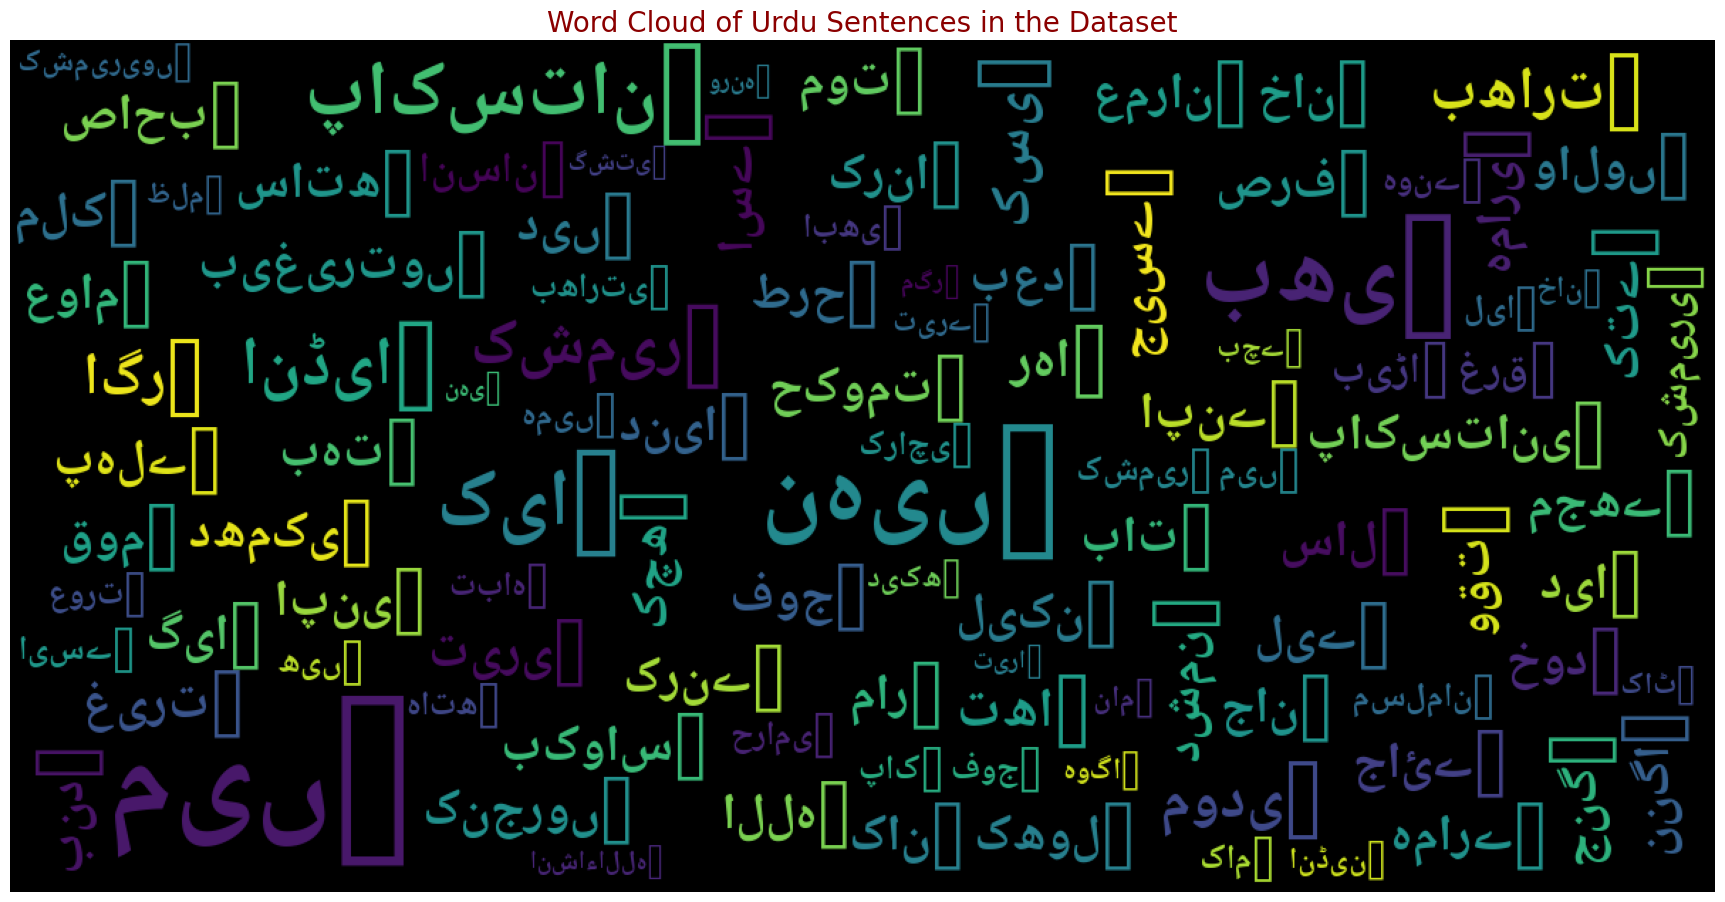

In [26]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
                font_path="/media/shirish/337c59f4-fc5e-4bd8-a7df-1ca3c23827fa/shirish/Desktop/IIIT_RANCHI/Urdu-threat-detection-FIRE2022/NotoNaskhArabic-Bold.ttf",
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(22,22))
    plt.axis('off')
    plt.title("Word Cloud of Urdu Sentences in the Dataset",fontdict=font_2)

    plt.imshow(wordcloud)
    plt.savefig("WordCloudPlot_b.jpg",bbox_inches="tight")
    plt.show()
    
show_wordcloud(corpus)

In [27]:
#Getting the most related n-grams 

"""
While using the tfdfvecotrizer we keep in mind to put norm equal to l2 so that all the feature vectors 
have a eucledian norm of l1. sublinear_tf is set to true to use logarithmic frequency
ngram is set to (1,2) so that we consider both unigram and bi-gram 
we also use stopwords in urdu to reduce the noise of the data and make feautres more useful
"""
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(sublinear_tf=True, 
                         min_df=5, norm='l2',
                         ngram_range=(1, 2), 
                         stop_words=stopwords)
features = tf_idf.fit_transform(df.Tweets).toarray()
labels = df["label"]
print(f"The shape of features is {features.shape}\n and the shape of labels is {labels.shape}")

The shape of features is (3564, 2175)
 and the shape of labels is (3564,)


In [28]:
# a glimpse of features and labels 
print(features,"\n\n", labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

 0       1
1       1
2       1
3       1
4       1
       ..
3559    0
3560    0
3561    0
3562    0
3563    0
Name: label, Length: 3564, dtype: int64


In [29]:
#saving the pre processed data 
df.to_csv("Train_Clean.csv",index=False)
df_test.to_csv("Test_Clean.csv",index=False)

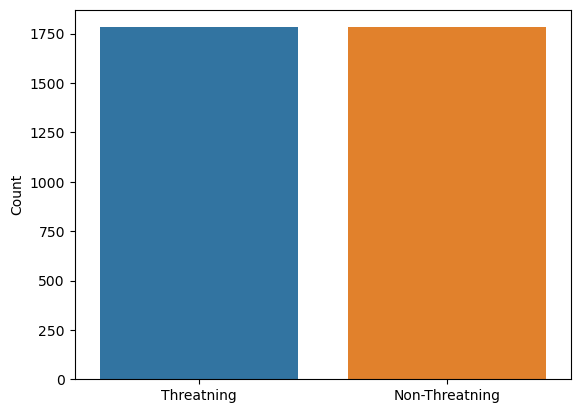

In [230]:
Threatening = df[df['label'] == 1].shape[0]
Non_Threatening=df[df['label'] == 0].shape[0]
data=[Threatening,Non_Threatening]
label=["Threatning","Non-Threatning"]
sn.barplot(x=label,y=data)
plt.ylabel("Count")
plt.savefig("Class.jpeg",bobx_inches="tight")
plt.show()

In [225]:
help(sn.barplot)

Help on function barplot in module seaborn.categorical:

barplot(*, x=None, y=None, hue=None, data=None, order=None, hue_order=None, estimator=<function mean at 0x7f3a045ea310>, ci=95, n_boot=1000, units=None, seed=None, orient=None, color=None, palette=None, saturation=0.75, errcolor='.26', errwidth=None, capsize=None, dodge=True, ax=None, **kwargs)
    Show point estimates and confidence intervals as rectangular bars.
    
    A bar plot represents an estimate of central tendency for a numeric
    variable with the height of each rectangle and provides some indication of
    the uncertainty around that estimate using error bars. Bar plots include 0
    in the quantitative axis range, and they are a good choice when 0 is a
    meaningful value for the quantitative variable, and you want to make
    comparisons against it.
    
    For datasets where 0 is not a meaningful value, a point plot will allow you
    to focus on differences between levels of one or more categorical
    variab

# Sub-Task 1

## Machine Learning

In [5]:

df=pd.read_csv("Train_Clean.csv")
df_test=pd.read_csv("Test_Clean.csv")
df,df_test

(                                                 Tweets  label  S/G  \
 0                                             بکواس مت       1    1   
 1        تمہاری ہیجڑا فورس نہتے سامنے بکری بنی ڈوب مرو       1    0   
 2     آفیسر سمیتبھارتی فوجی جہنم واصلبنکرز تباہ بھار...      1    1   
 3                       غدار منافق میر اللہ تمہیں زلیل       1    1   
 4     اگست آپ بھارت کو کیا پیغام دینا چاہیں میرا پیغ...      1    0   
 ...                                                 ...    ...  ...   
 3559                   ارے شعر حقیقت میں پیچھے نا پڑنا       0    2   
 3560  ہندوستانی باوردی غنڈا ایل او سی پتھر مار چیک ک...      0    2   
 3561                                  خبر افسوس ناک ھے       0    2   
 3562  جناب محترم سلمان وفادارصاھب کیا پارلیمنٹ آئینی...      0    2   
 3563                 قد لڑکی شہد مکھی دونوں بہت خطرناک       0    2   
 
       word_count  char_count  word_density  
 0              2           7      0.250000  
 1              9          37      0.23684

In [7]:
#splitting the dataset into train and test with ratio of 80:20
x_train=df["Tweets"]
y_train=df["S/G"]
x_test=df_test["Tweet"]
y_test=df_test["G/S"]
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3564,), (935,), (3564,), (935,))

In [10]:
#vectorizing the urdu statements using the Term frequency and inverse document frequency
from sklearn.feature_extraction.text import TfidfVectorizer
max_feature_num = 50000
vectorizer = TfidfVectorizer(max_features=max_feature_num)
train_vecs = vectorizer.fit_transform(x_train)
test_vecs = TfidfVectorizer(max_features=max_feature_num, vocabulary=vectorizer.vocabulary_).fit_transform(x_test)
# visualizing the shape of train and test vecs
train_vecs.shape,test_vecs.shape


((3564, 7642), (935, 7642))

In [11]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(train_vecs.toarray(),test_vecs.toarray(),np.array(y_train),np.array(y_test))
models
# type(train_vecs)

100%|███████████████████████████████████████████| 29/29 [15:23<00:00, 31.83s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.50,0.44,None,0.52,3.13
Perceptron,0.54,0.43,None,0.54,2.17
BernoulliNB,0.60,0.42,None,0.56,0.91
NearestCentroid,0.51,0.41,None,0.53,0.93
CalibratedClassifierCV,0.59,0.40,None,0.53,484.21
LinearDiscriminantAnalysis,0.52,0.39,None,0.56,38.64
ExtraTreesClassifier,0.59,0.39,None,0.54,20.71
PassiveAggressiveClassifier,0.44,0.39,None,0.49,5.01
SVC,0.60,0.39,None,0.54,72.45


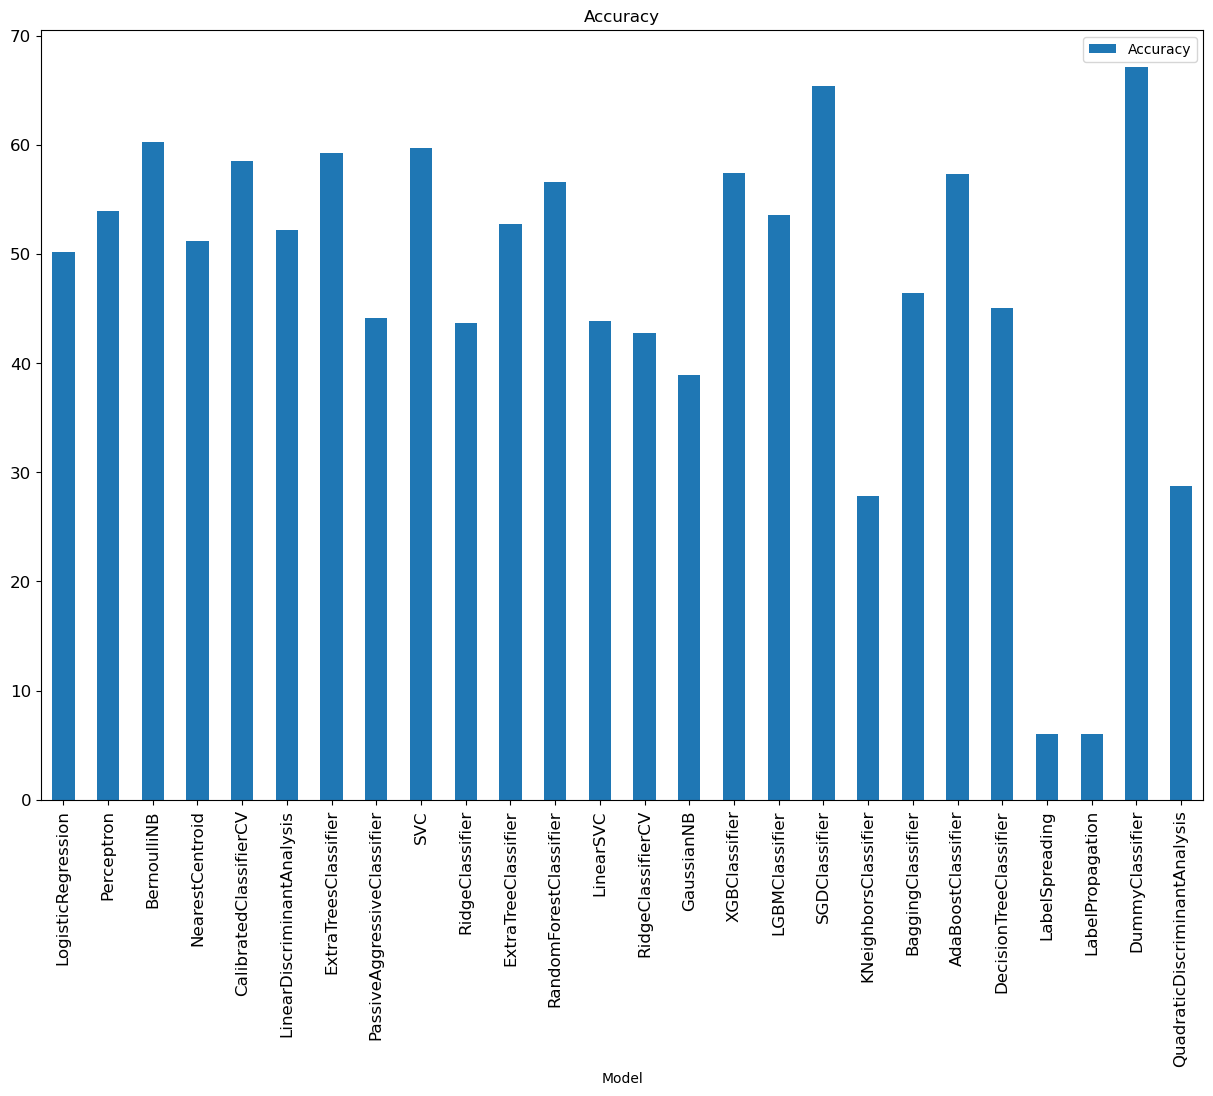

In [12]:
ax = (models["Accuracy"]*100).plot(kind='bar', title ="Accuracy", figsize=(15, 10), legend=True, fontsize=12)
plt.savefig("Comparison_all_models_part2.jpg",bbox_inches="tight")
plt.show()

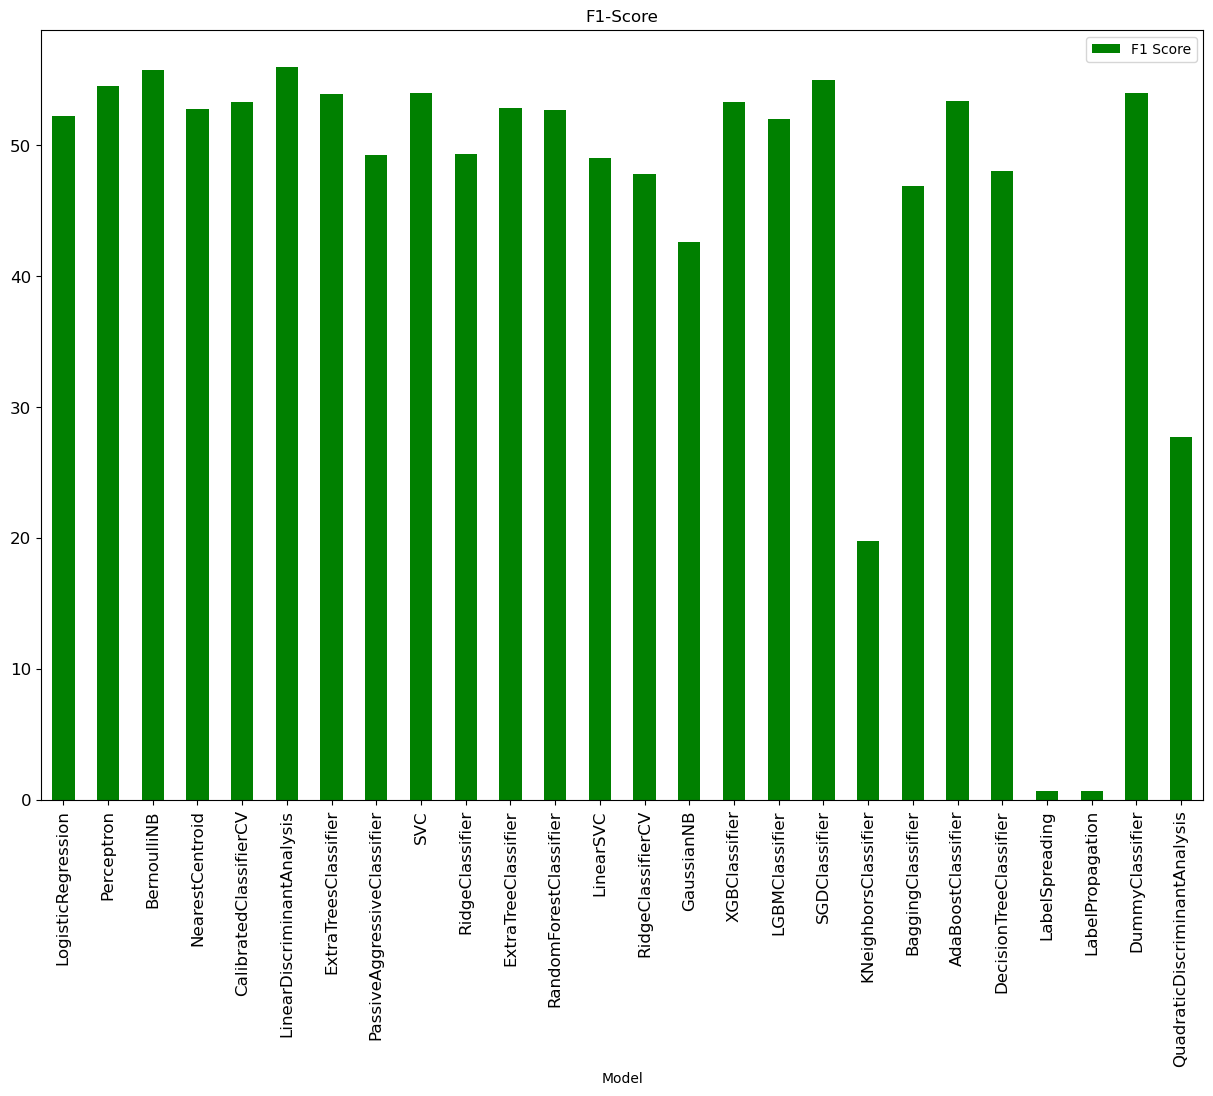

In [13]:
ax = (models["F1 Score"]*100).plot(kind='bar', title ="F1-Score", figsize=(15, 10), legend=True, fontsize=12,color="g")
plt.savefig("Comparison_all_models_f1_part2.jpg",bbox_inches="tight")
plt.show()

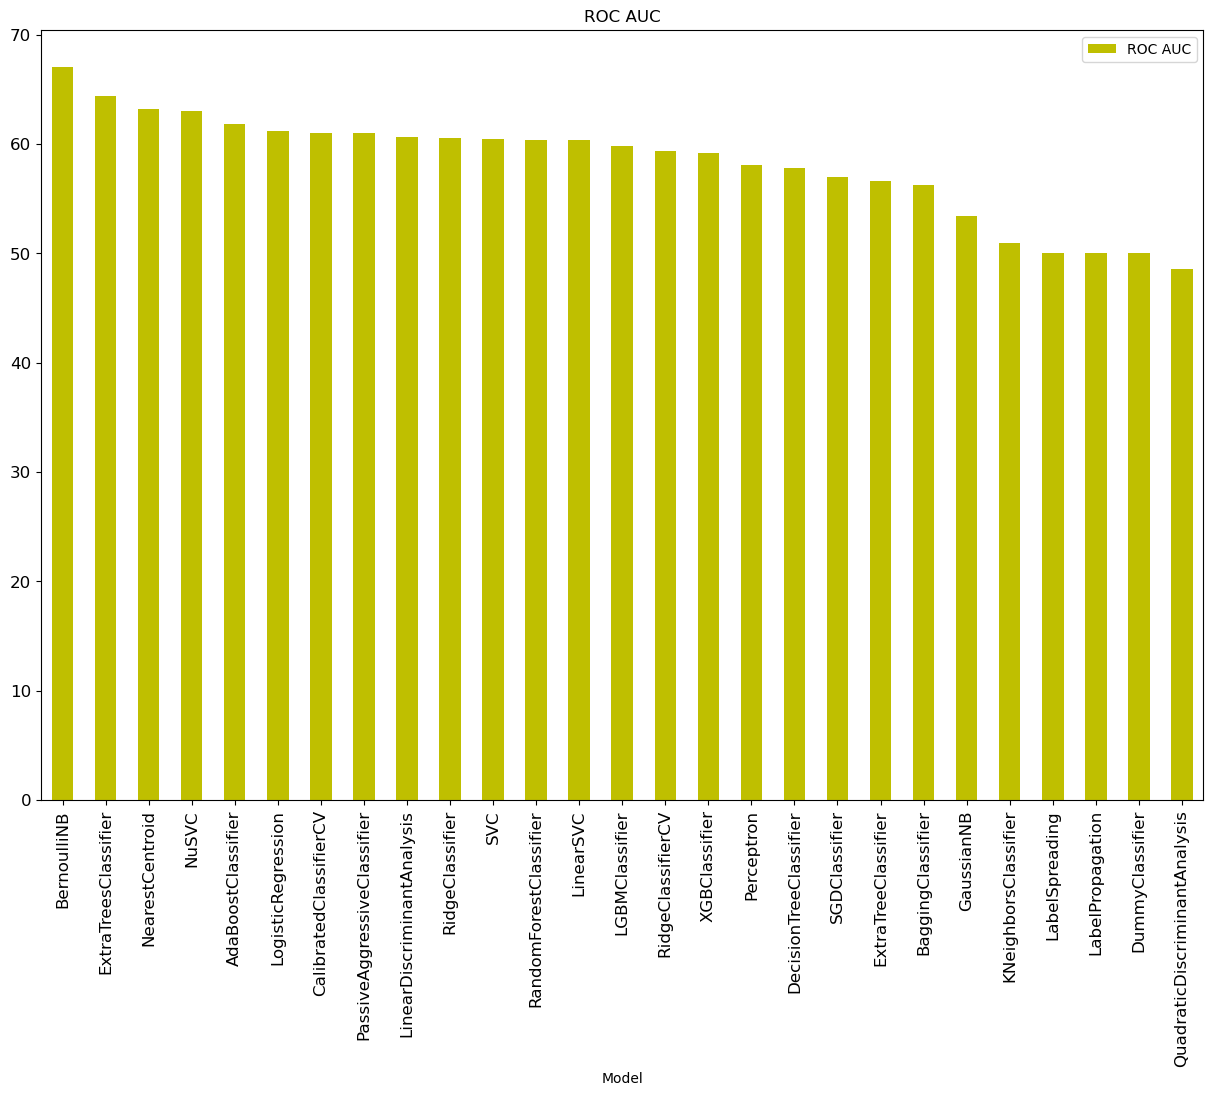

In [201]:
ax = (models["ROC AUC"]*100).plot(kind='bar', title ="ROC AUC", figsize=(15, 10), legend=True, fontsize=12,color="y")
plt.savefig("Comparison_all_models_roc.jpg",bbox_inches="tight")
plt.show()

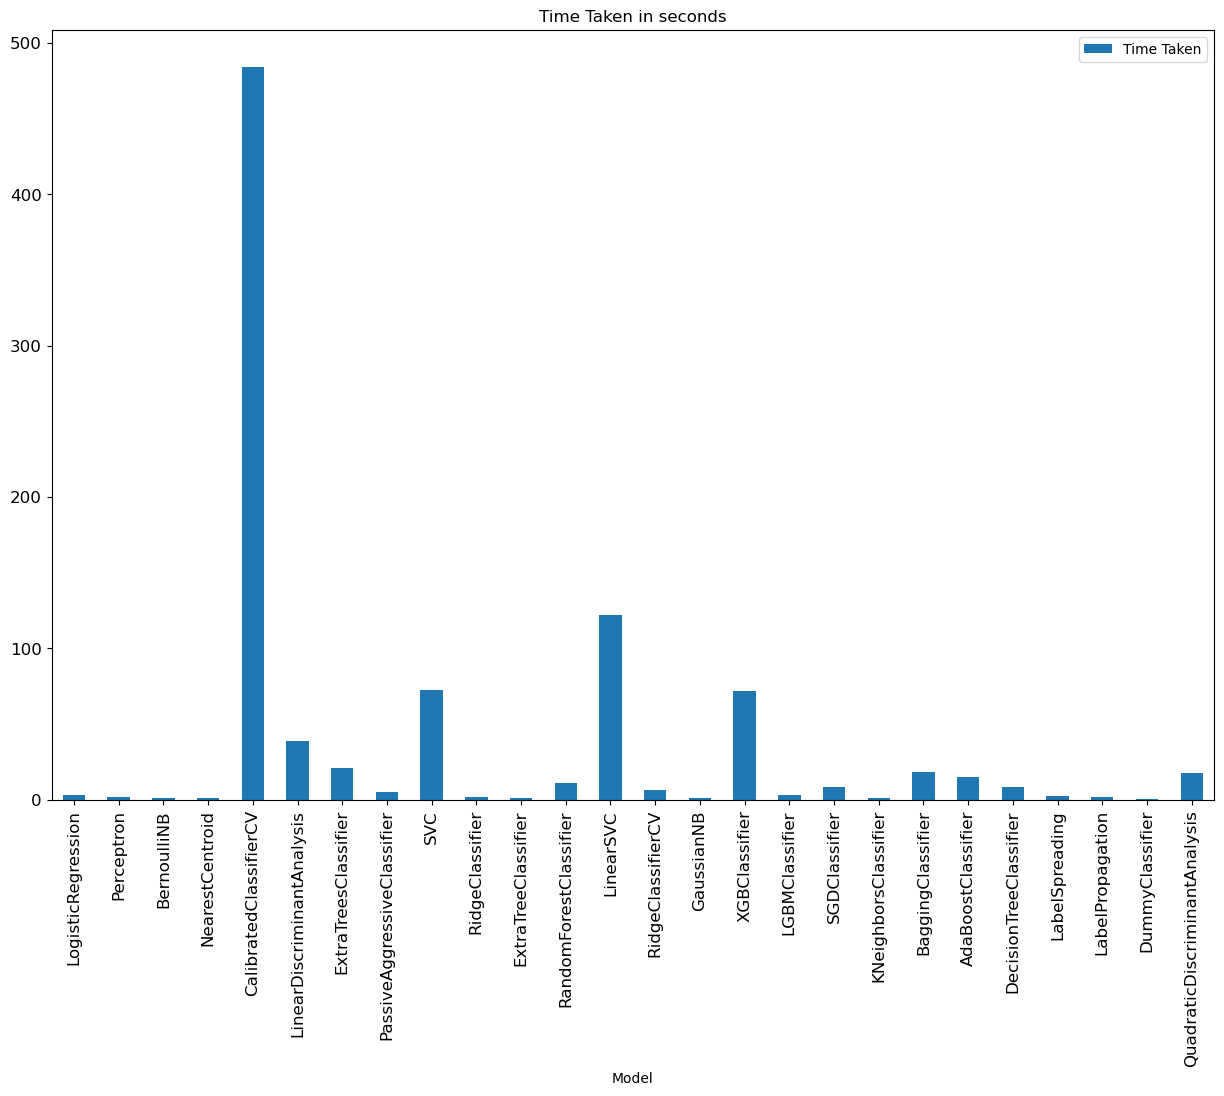

In [14]:
ax = (models["Time Taken"]).plot(kind='bar', title ="Time Taken in seconds", figsize=(15, 10), legend=True, fontsize=12)
plt.savefig("Comparison_all_models_time_part2.jpg",bbox_inches="tight")
plt.show()

In [15]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB

In [42]:
#transforming problem using the labelpowerset technique

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
def build_model(model,xtrain,ytrain,xtest,ytest):
    clf = model
    clf.fit(xtrain,ytrain)
    clf_predictions = clf.predict(xtest)
    acc = accuracy_score(ytest,clf_predictions)
    f_1_score = f1_score(ytest,clf_predictions)
    roc_auc=roc_auc_score(ytest,clf_predictions)
    result = {"accuracy:":acc,"f1_score":f_1_score,"ROC_AUC":roc_auc}
    return result

In [43]:
#creating a model based on Multinomial Naive Bayes
clf_model_1=build_model(MultinomialNB(),train_vecs,y_train,test_vecs,y_test)
#results
clf_model_1

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [35]:
from sklearn.svm import LinearSVC 
#building svm classifier
clf_model_2=build_model(LinearSVC(),train_vecs,y_train,test_vecs,y_test)
#getting results 
clf_model_2

AxisError: axis 1 is out of bounds for array of dimension 1

In [39]:
#implementing KNN 
from sklearn.neighbors import KNeighborsClassifier
clf_model_3=build_model(KNeighborsClassifier(),train_vecs,y_train,test_vecs,y_test)
clf_model_3

{'accuracy:': 0.5850267379679145,
 'f1_score': 0.5,
 'ROC_AUC': 0.5970118674661299}

In [40]:
#implementing Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier as DTC
clf_model_4=build_model(DTC(),train_vecs,y_train,test_vecs,y_test)
clf_model_4

{'accuracy:': 0.597860962566845,
 'f1_score': 0.4534883720930233,
 'ROC_AUC': 0.57493153384925}

In [41]:
#implementing adaboost classifier 
from sklearn.ensemble import AdaBoostClassifier as ABC
clf_model_5=build_model(ABC(),train_vecs,y_train,test_vecs,y_test)
clf_model_5

{'accuracy:': 0.6834224598930482,
 'f1_score': 0.4695340501792115,
 'ROC_AUC': 0.6178136475860496}

In [42]:
#implementing random forest classifier 
from sklearn.ensemble import RandomForestClassifier as RFC
clf_model_6=build_model(RFC(),train_vecs,y_train,test_vecs,y_test)
clf_model_6

{'accuracy:': 0.6181818181818182,
 'f1_score': 0.4711111111111111,
 'ROC_AUC': 0.5925563808377767}

In [78]:
#implementing logistic regression 
from sklearn.linear_model import LogisticRegression as LR 
clf_model_7=build_model(LR(),train_vecs,y_train,test_vecs,y_test)
clf_model_7

{'accuracy:': 0.6855614973262032,
 'f1_score': 0.5318471337579618,
 'ROC_AUC': 0.6493755057158862}

In [79]:
models=[clf_model_1,clf_model_2,clf_model_3,clf_model_4,clf_model_5,clf_model_6,clf_model_7]
accuracy=[]
f1=[]
roc=[]
for j in models:
#     names.append("model_{j}")
    accuracy.append(j["accuracy:"]*100)
    f1.append(j["f1_score"]*100)
    roc.append(j["ROC_AUC"]*100)
accuracy,f1,roc

([65.24064171122996,
  65.56149732620321,
  58.50267379679145,
  59.786096256684495,
  68.34224598930481,
  61.81818181818181,
  68.55614973262033],
 [58.172458172458164,
  52.64705882352941,
  50.0,
  45.34883720930233,
  46.95340501792115,
  47.11111111111111,
  53.18471337579618],
 [67.38106599721985,
  63.70723458992925,
  59.70118674661299,
  57.493153384925,
  61.781364758604965,
  59.255638083777676,
  64.93755057158862])

In [218]:
import matplotlib.pyplot as plt 
%matplotlib inline
names=["MNB","SVM","KNN","DTree","AdaBoost","RF","LogisticRegression"]

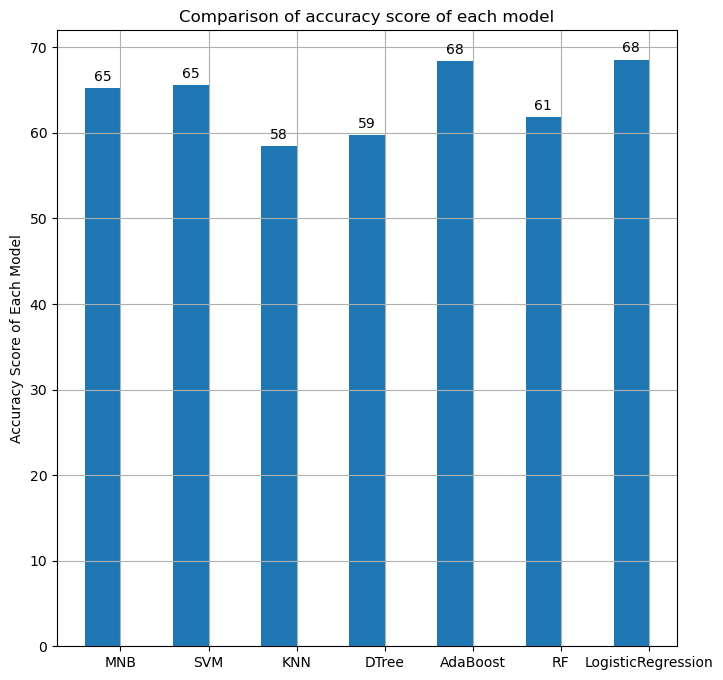

In [83]:
x = np.arange(7) # the label locations
width =0.4

fig, ax = plt.subplots(figsize=(8,8))

ax.set_ylabel('Accuracy Score of Each Model')
ax.set_title('Comparison of accuracy score of each model')
ax.set_xticks(x)
ax.set_xticklabels(names)

pps = ax.bar(x - width/2, accuracy, width)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(int(height)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
plt.grid(True)
plt.savefig("Comparison_of_ML_Model_ACC_b.jpg",bbox_inches="tight")
plt.show()

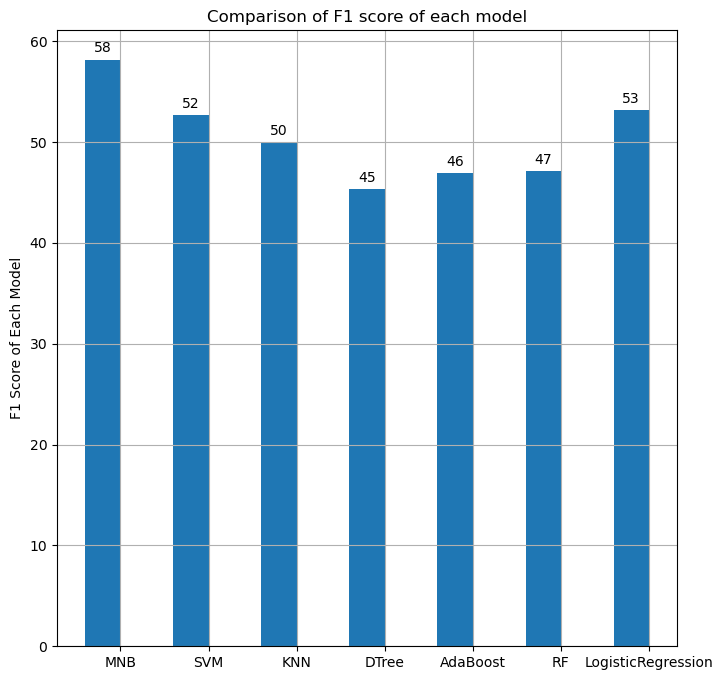

In [84]:
x = np.arange(7) # the label locations
width =0.4

fig, ax = plt.subplots(figsize=(8,8))

ax.set_ylabel('F1 Score of Each Model')
ax.set_title('Comparison of F1 score of each model')
ax.set_xticks(x)
ax.set_xticklabels(names)

pps = ax.bar(x - width/2, f1, width)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(int(height)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
plt.grid(True)
plt.savefig("Comparison_of_ML_Model_F1_b.jpg",bbox_inches="tight")
plt.show()

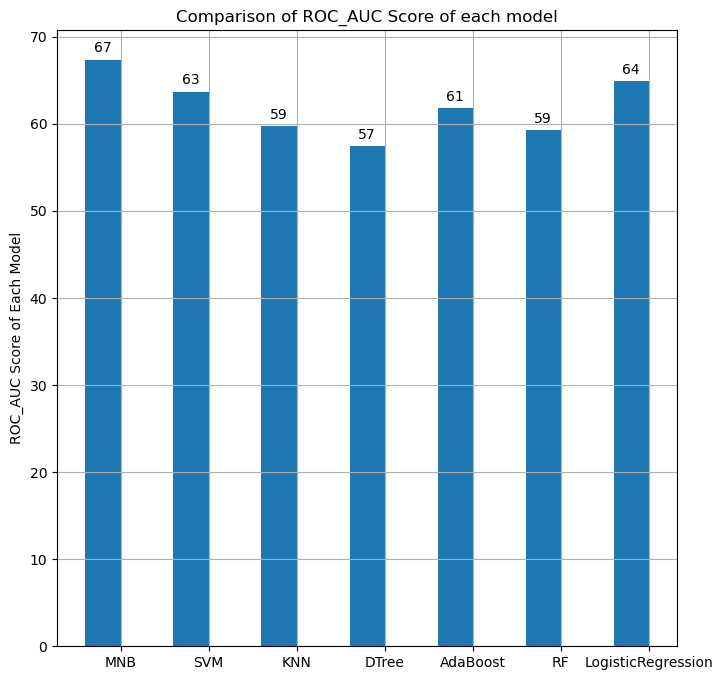

In [85]:
x = np.arange(7) # the label locations
width =0.4

fig, ax = plt.subplots(figsize=(8,8))

ax.set_ylabel('ROC_AUC Score of Each Model')
ax.set_title('Comparison of ROC_AUC Score of each model')
ax.set_xticks(x)
ax.set_xticklabels(names)

pps = ax.bar(x - width/2, roc, width)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(int(height)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
plt.grid(True)
plt.savefig("Comparison_of_ML_Model_ROC_AUC.jpg",bbox_inches="tight")
plt.show()

## Using Grid Search CV for Hyper Parameter Tuning

In [157]:
# based on accuracy and roc_auc score we have MNB and Adabosst, Logistic Regression and RF as one of the best models
#we will be tuning them one by one 
from sklearn.model_selection import GridSearchCV

#fine tuning the parameters of logistic regression 
param_1={"penalty":["l1","l2",None,"elasticnet"],
         "C":[1,2,3],
         "class_weight":["balanced",None]
        }
tuned_model_1=GridSearchCV(LR(random_state=42),
                           param_grid=param_1,
                           scoring="accuracy", 
                           n_jobs=2,
                           cv=10, 
                           verbose=1)
tuned_model_1.fit(train_vecs,y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42), n_jobs=2,
             param_grid={'C': [1, 2, 3], 'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2', None, 'elasticnet']},
             scoring='accuracy', verbose=1)

In [158]:
print("tuned hpyerparameters :(best parameters) ",tuned_model_1.best_params_)
print("accuracy :",tuned_model_1.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 2, 'class_weight': 'balanced', 'penalty': 'l2'}
accuracy : 0.7157767601422591


In [159]:
#using fine tuned Logistic Regression Model
#implementing logistic regression 
model_1=build_model(LR(C=2,class_weight="balanced",penalty="l2",random_state=42),train_vecs,y_train,test_vecs,y_test)
model_1

{'accuracy:': 0.6737967914438503,
 'f1_score': 0.521193092621664,
 'ROC_AUC': 0.6397850577812818}

In [160]:
#fine tuning SVM 
param_2={"penalty":["l1","l2"],
        "loss":["hinge","square_hinge"],
        "C":[1,2,3],
        "class_weight":["balanced",None],
        }
tuned_model_2=GridSearchCV(LinearSVC(random_state=42),
                           param_grid=param_2,
                           scoring="accuracy",
                           n_jobs=2,
                           verbose=1,
                           cv=10)
tuned_model_2.fit(train_vecs,y_train)
                           

Fitting 10 folds for each of 24 candidates, totalling 240 fits


/home/shirish/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/shirish/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=10, estimator=LinearSVC(random_state=42), n_jobs=2,
             param_grid={'C': [1, 2, 3], 'class_weight': ['balanced', None],
                         'loss': ['hinge', 'square_hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

In [161]:
print("tuned hpyerparameters :(best parameters) ",tuned_model_2.best_params_)
print("accuracy :",tuned_model_2.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'class_weight': 'balanced', 'loss': 'hinge', 'penalty': 'l2'}
accuracy : 0.7135279954678501


In [163]:
#implementing the fine tuned svm 
model_2=build_model(LinearSVC(C=1,class_weight="balanced",loss="hinge",penalty="l2",random_state=42),train_vecs,y_train,test_vecs,y_test)
model_2

{'accuracy:': 0.6748663101604279,
 'f1_score': 0.5323076923076924,
 'ROC_AUC': 0.6464086391833855}

In [ ]:
#fine tune 

## Using Unigram, Bigram and Trigram as feautres

In [71]:
#gettting bi-grams

def generate_bi_grams(text,ngram=2):
  words=[word for word in text.split(" ") if word not in stopwords]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans[i] for i in range(0,len(ans))
def generate_uni_grams(text,ngram=1):
  words=[word for word in text.split(" ") if word not in stopwords]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans
def generate_tri_grams(text,ngram=3):
  words=[word for word in text.split(" ") if word not in stopwords]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans
# for train data
df["uni_grams"]=df["Tweets"].apply(generate_uni_grams)
df["bi_grams"]=df["Tweets"].apply(generate_bi_grams)
df["tri_grams"]=df["Tweets"].apply(generate_tri_grams)
display(df)

SyntaxError: invalid syntax (4126623028.py, line 7)

In [64]:
#for testing data 
df_test["uni_grams"]=df_test["Tweet"].apply(generate_uni_grams)
df_test["bi_grams"]=df_test["Tweet"].apply(generate_bi_grams)
df_test["tri_grams"]=df_test["Tweet"].apply(generate_tri_grams)
display(df_test)

,Tweet,Threat,G/S,uni_grams,bi_grams,tri_grams
0,وزیراعل پنجاب کا ضلع راولپنڈی کا دورہ لینڈسلائ...,0,2,"[وزیراعل, پنجاب, کا, ضلع, راولپنڈی, کا, دورہ, ...","[وزیراعل پنجاب, پنجاب کا, کا ضلع, ضلع راولپنڈی...","[وزیراعل پنجاب کا, پنجاب کا ضلع, کا ضلع راولپن..."
1,الحمدللہ پورے پاکستان وکلاء برادری کا کہنا ہم ...,1,1,"[الحمدللہ, پورے, پاکستان, وکلاء, برادری, کا, ک...","[الحمدللہ پورے, پورے پاکستان, پاکستان وکلاء, و...","[الحمدللہ پورے پاکستان, پورے پاکستان وکلاء, پا..."
2,جنوری مہلت ختم الٹی گنتی شروع ن لیگ خلاف بڑی ک...,1,1,"[جنوری, مہلت, ختم, الٹی, گنتی, شروع, ن, لیگ, خ...","[جنوری مہلت, مہلت ختم, ختم الٹی, الٹی گنتی, گن...","[جنوری مہلت ختم, مہلت ختم الٹی, ختم الٹی گنتی,..."
3,کروناکی آڑ میں حکومت اورفوج جوکھیل قادیانیوں ک...,1,1,"[کروناکی, آڑ, میں, حکومت, اورفوج, جوکھیل, قادی...","[کروناکی آڑ, آڑ میں, میں حکومت, حکومت اورفوج, ...","[کروناکی آڑ میں, آڑ میں حکومت, میں حکومت اورفو..."
4,حکومت ایکشن میں ورنہ اگر ہم ایکشن میں آگئے ہم ...,1,1,"[حکومت, ایکشن, میں, ورنہ, اگر, ہم, ایکشن, میں,...","[حکومت ایکشن, ایکشن میں, میں ورنہ, ورنہ اگر, ا...","[حکومت ایکشن میں, ایکشن میں ورنہ, میں ورنہ اگر..."
...,...,...,...,...,...,...
930,کوئ پیڈ جیالوں کو بتا عمران احمد خان نیازی نام...,1,1,"[کوئ, پیڈ, جیالوں, کو, بتا, عمران, احمد, خان, ...","[کوئ پیڈ, پیڈ جیالوں, جیالوں کو, کو بتا, بتا ع...","[کوئ پیڈ جیالوں, پیڈ جیالوں کو, جیالوں کو بتا,..."
931,مجبور نہ قانون ہاتھ میں دین اسلام خلاف بھی قان...,1,1,"[مجبور, نہ, قانون, ہاتھ, میں, دین, اسلام, خلاف...","[مجبور نہ, نہ قانون, قانون ہاتھ, ہاتھ میں, میں...","[مجبور نہ قانون, نہ قانون ہاتھ, قانون ہاتھ میں..."
932,ڈرامہ سیاست زلیل گہٹیا غلطی نہیں مانیں,0,2,"[ڈرامہ, سیاست, زلیل, گہٹیا, غلطی, نہیں, مانیں, ]","[ڈرامہ سیاست, سیاست زلیل, زلیل گہٹیا, گہٹیا غل...","[ڈرامہ سیاست زلیل, سیاست زلیل گہٹیا, زلیل گہٹی..."
933,وزیراعظم صاحب آپ کا اتنی جلد بازی کا فیصلہ آپ ...,0,2,"[وزیراعظم, صاحب, آپ, کا, اتنی, جلد, بازی, کا, ...","[وزیراعظم صاحب, صاحب آپ, آپ کا, کا اتنی, اتنی ...","[وزیراعظم صاحب آپ, صاحب آپ کا, آپ کا اتنی, کا ..."


In [65]:
#saving the modified csv 
#saving the pre processed data 
df.to_csv("Modified_Train_Clean_b.csv",index=False)
df_test.to_csv("Modified_Test_Clean_b.csv",index=False)

In [ ]:
te=df["uni"]

## Using Uni-Gram and Tweets as features

# create a bag of words for only unigrams
cv = CountVectorizer(analyzer = 'word',ngram_range=(3,3), stop_words=stopwords)
temp=df["tri_grams"]
temp_test=df_test["tri_grams"]
# convert training data to bag of words
X_train_cv = cv.fit_transform(temp)
X_test_cv = cv.transform(temp_test)